In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore
import asyncio

#st.set_option('deprecation.showPyplotGlobalUse', False)

#st.write(datetime.now()+ timedelta(hours=2))


import requests
import telegram
import google.generativeai as genai


In [3]:
def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df



def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run




valid_run = get_last_arome_run()

In [3]:
aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado Madrid.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)

aemet_horario_acumulado

,Temperatura (ºC),Velocidad del viento (km/h),Dirección del viento,Racha (km/h),Dirección de racha,Precipitación (mm),Presión (hPa),Tendencia (hPa),Humedad (%)
Fecha y hora oficial,,,,,,,,,
2025-08-06 19:00:00,37.0,6,Noroeste,23,Oeste,0.0,938.8,-0.9,14.0
2025-08-06 18:00:00,36.9,8,Sudeste,22,Norte,0.0,939.0,-1.7,15.0
2025-08-06 17:00:00,37.0,10,Noroeste,21,Oeste,0.0,939.3,-1.9,16.0
2025-08-06 16:00:00,36.9,4,Sudoeste,23,Sur,0.0,939.7,-1.8,20.0
2025-08-06 15:00:00,37.0,10,Sudeste,21,Sudeste,0.0,940.7,-1.0,20.0
...,...,...,...,...,...,...,...,...,...
2023-08-10 00:00:00,30.9,2,Sudoeste,17,Oeste,0.0,942.8,1.3,34.0
2023-08-09 23:00:00,31.8,6,Oeste,17,Oeste,0.0,942.4,1.3,34.0
2023-08-09 22:00:00,32.5,9,Oeste,15,Oeste,0.0,942.0,0.3,30.0


In [4]:
def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data

temp_data = get_temp_data(valid_run)
wind_gust_data = get_wind_gust_data(valid_run)
pressure_data = get_pressure_data(valid_run)
mucape_data = get_mucape_data(valid_run)
prec_data = get_prec_data(valid_run)


In [6]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2025-11-24 10:00:00+01:00 to 2025-11-26 13:00:00+01:00
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ctrl    52 non-null     float64
 1   1       52 non-null     float64
 2   2       52 non-null     float64
 3   3       52 non-null     float64
 4   4       52 non-null     float64
 5   5       52 non-null     float64
 6   6       52 non-null     float64
 7   7       52 non-null     float64
 8   8       52 non-null     float64
 9   9       52 non-null     float64
 10  10      52 non-null     float64
 11  11      52 non-null     float64
 12  12      52 non-null     float64
 13  13      52 non-null     float64
 14  14      52 non-null     float64
 15  15      52 non-null     float64
 16  16      52 non-null     float64
 17  17      52 non-null     float64
 18  18      52 non-null     float64
 19  19      52 non-null     float64
 20  20      52 non-null     floa

In [6]:
datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

In [7]:
aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado Madrid.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)

In [8]:
def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()




def get_arome_data(url):

    #url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data


temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

In [9]:
def plot_temp_data(data):
        

        data = data
        # Set figure size and resolution
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

        # Set plot style
        plt.style.use('default')

        # Iterate over the columns and plot each one
        for column in data.columns[:-1]:
            ax.plot(data.index, data[column], alpha=0.9)

        ax.plot(data["Actual data"], alpha=1,linewidth=4,color="black")

        # Add title and labels


        plt.title('Temperature Forecast for the next 2 days', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Temperature (°C)', fontsize=12)



        # Remove top and right spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Set x-axis tick parameters
        plt.xticks(fontsize=10, rotation=0, ha='right')

        # Set y-axis tick parameters
        plt.yticks(fontsize=10)

        # Add vertical lines for each hour
        for hour in data.index:
            ax.axvline(hour, linestyle='--', color='black', alpha=0.1)

        # Remove gridlines
        plt.grid(True)

        # Compute the minimum and maximum temperature for each day and their respective indexes
        dates = list(set(data.index.date))
        min_temps = []
        max_temps = []
        min_idx = []
        max_idx = []

        for date in dates:
            df = data.loc[data.index.date == date]
            min_temp = df.min().min()
            max_temp = df.max().max()
            min_idx.append(data.loc[data.index.date == date].idxmin().min())
            max_idx.append(data.loc[data.index.date == date].idxmax().min())
            min_temps.append(min_temp)
            max_temps.append(max_temp)

        # Add the minimum temperature text to the plot
        for i, temp in enumerate(min_temps):
            min_temp = "{:.1f}".format(temp)
            ax.text(min_idx[i], temp, min_temp, ha='left', va='top', color='blue',fontweight="bold")

        # Add the maximum temperature text to the plot
        for i, temp in enumerate(max_temps):
            max_temp = "{:.1f}".format(temp)
            ax.text(max_idx[i], temp, max_temp, ha='left', va='bottom', color='red',fontweight="bold")


        max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
        max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

        ax.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

        min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
        min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

        ax.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')



        # Format x-axis ticks
        # Format x-axis ticks
        ticks = []
        tick_labels = []
        for date in data.index:
                if date.hour == 0:
                    tick_labels.append(date.strftime('%A %d %B'))
                    ticks.append(date)
                    ax.axvline(date,0,1,color="black",linewidth=2)
                if date.hour % 6 == 0:
                    tick_labels.append(date.strftime('%H'))
                    ticks.append(date)
                    pass

        ax.set_xticks(ticks);
        ax.set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center');

        return 


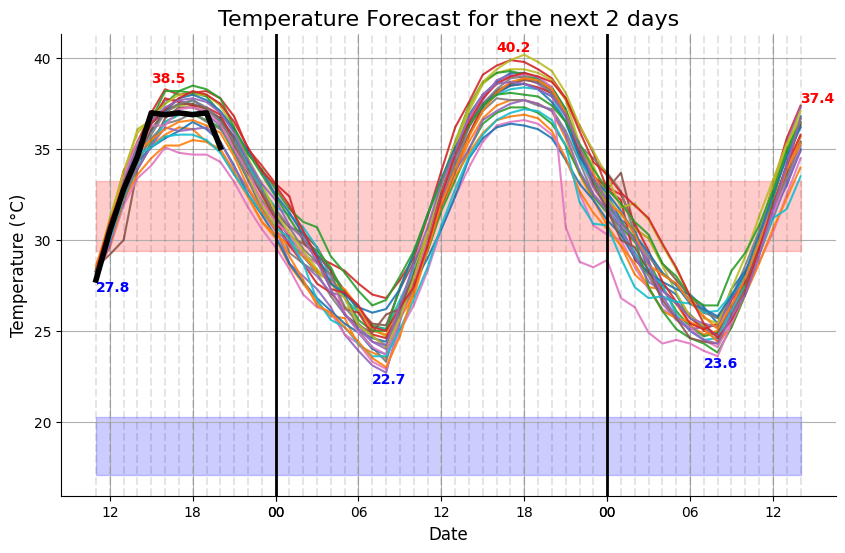

In [10]:
plot_temp_data(temp_data)

🌤️  AROME Madrid - Animación Meteorológica

🔄 Obteniendo datos...
Obteniendo datos de 25 ubicaciones...
✓ Point_0_0: 52 registros
✓ Point_0_1: 52 registros
✓ Point_0_3: 52 registros
✓ Point_0_4: 52 registros
✓ Point_1_0: 52 registros
✓ Point_0_2: 52 registros
✓ Point_1_1: 52 registros
✓ Point_1_3: 52 registros
✓ Point_1_2: 52 registros
✓ Point_1_4: 52 registros
✓ Point_2_0: 52 registros
✓ Point_2_1: 52 registros
✓ Point_2_2: 52 registros
✓ Point_2_3: 52 registros
✓ Point_3_0: 52 registros
✓ Point_3_1: 52 registros
✓ Point_3_2: 52 registros
✓ Point_3_4: 52 registros
✓ Point_4_0: 52 registros
✓ Point_3_3: 52 registros
✓ Point_4_1: 52 registros
✓ Point_4_2: 52 registros
✓ Point_4_3: 52 registros
✓ Point_4_4: 52 registros
✓ Point_2_4: 52 registros

✅ Completado: 25 ubicaciones exitosas

📊 Datos obtenidos:
   Registros: 1300
   Ubicaciones: 25
   Timestamps: 52
   Columnas: ['Ctrl', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'

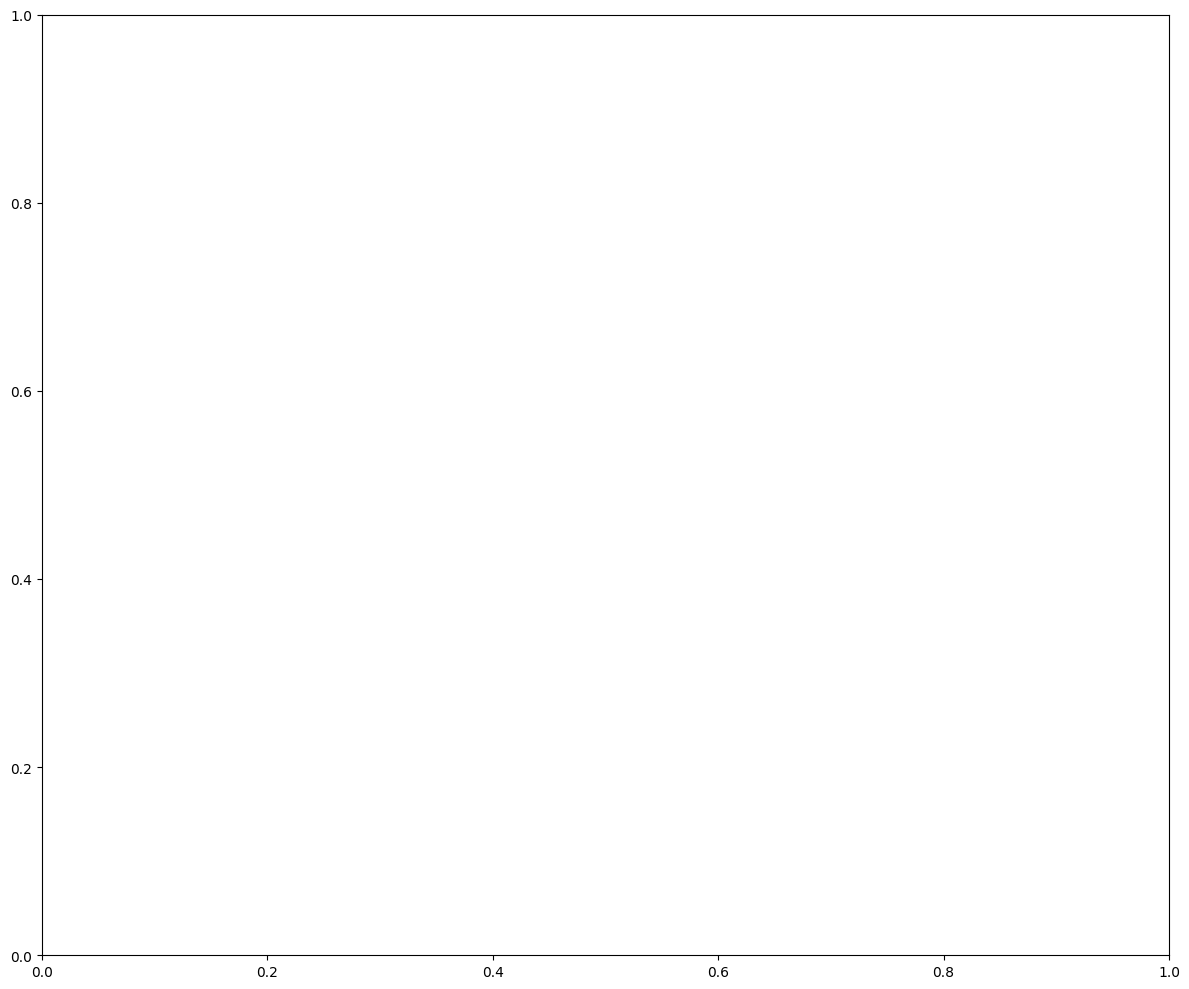

✅ Animación creada y mostrada!


In [16]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import griddata
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings

warnings.filterwarnings('ignore')

def get_arome_data(url):
    """
    Función original para extraer datos AROME de Meteociel
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    if not table:
        return None

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])
    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date", axis=1)
    df = df.drop("Ech.", axis=1)
    df = df.astype("float")

    return df

def generate_grid_locations(center_lat=40.41, center_lon=-3.658, grid_size=10, spacing=0.015):
    """
    Genera una grilla simple de ubicaciones alrededor del centro especificado
    """
    # Calcular rango para centrar la grilla
    half_range = (grid_size - 1) / 2 * spacing
    
    lat_range = np.linspace(center_lat - half_range, center_lat + half_range, grid_size)
    lon_range = np.linspace(center_lon - half_range, center_lon + half_range, grid_size)
    
    locations = []
    for i, lat in enumerate(lat_range):
        for j, lon in enumerate(lon_range):
            locations.append({
                'name': f'Point_{i}_{j}',
                'lat': round(lat, 4),
                'lon': round(lon, 4)
            })
    
    return locations

def build_arome_url(lat, lon):
    """
    Construye URL para AROME (manteniendo los parámetros originales)
    """
    return f'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat={lat}&lon={lon}&mode=8&sort=0'

def scrape_location_data(location):
    """
    Obtiene datos para una ubicación específica
    """
    url = build_arome_url(location['lat'], location['lon'])
    
    try:
        df = get_arome_data(url)
        
        if df is not None and not df.empty and 'Ctrl' in df.columns:
            # Añadir información de ubicación
            df['lat'] = location['lat']
            df['lon'] = location['lon']
            df['location'] = location['name']
            
            print(f"✓ {location['name']}: {len(df)} registros")
            return df
        else:
            print(f"✗ {location['name']}: Sin datos o sin columna Ctrl")
            return None
            
    except Exception as e:
        print(f"✗ {location['name']}: Error - {e}")
        return None

def scrape_all_locations(grid_size=7, max_workers=3):
    """
    Obtiene datos de todas las ubicaciones en la grilla
    """
    locations = generate_grid_locations(grid_size=grid_size)
    all_dataframes = []
    
    print(f"Obteniendo datos de {len(locations)} ubicaciones...")
    
    def scrape_with_delay(location):
        result = scrape_location_data(location)
        time.sleep(1)  # Pausa para no saturar el servidor
        return result
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_location = {
            executor.submit(scrape_with_delay, loc): loc 
            for loc in locations
        }
        
        for future in as_completed(future_to_location):
            try:
                df = future.result()
                if df is not None:
                    all_dataframes.append(df)
            except Exception as e:
                print(f"Error: {e}")
    
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=False)
        print(f"\n✅ Completado: {len(all_dataframes)} ubicaciones exitosas")
        return combined_df
    else:
        print("\n❌ No se pudieron obtener datos")
        return pd.DataFrame()

def create_animated_weather_map(df, variable='Ctrl', title='Temperatura AROME Madrid'):
    """
    Crea una animación matplotlib de la variable meteorológica
    """
    if df.empty or variable not in df.columns:
        print(f"No hay datos para la variable {variable}")
        return None
    
    # Limpiar datos
    df_clean = df.dropna(subset=[variable, 'lat', 'lon'])
    
    if df_clean.empty:
        print("No hay datos válidos para crear la animación")
        return None
    
    # Obtener timestamps únicos y ordenarlos
    timestamps = sorted(df_clean.index.unique())
    
    if len(timestamps) == 0:
        print("No hay timestamps válidos")
        return None
    
    print(f"Creando animación con {len(timestamps)} frames...")
    
    # Configurar la figura
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.style.use('default')
    
    # Obtener límites de los datos para interpolación
    lats_all = df_clean['lat'].values
    lons_all = df_clean['lon'].values
    values_all = df_clean[variable].values
    
    lat_min, lat_max = lats_all.min() - 0.01, lats_all.max() + 0.01
    lon_min, lon_max = lons_all.min() - 0.01, lons_all.max() + 0.01
    
    # Crear grilla para interpolación
    lat_grid = np.linspace(lat_min, lat_max, 50)
    lon_grid = np.linspace(lon_min, lon_max, 50)
    LON, LAT = np.meshgrid(lon_grid, lat_grid)
    
    # Configurar colormap
    cmap = plt.cm.RdYlBu_r
    
    def animate_frame(frame_idx):
        ax.clear()
        
        if frame_idx >= len(timestamps):
            return
            
        timestamp = timestamps[frame_idx]
        frame_data = df_clean[df_clean.index == timestamp]
        
        if frame_data.empty:
            ax.text(0.5, 0.5, f'Sin datos para {timestamp}', 
                   transform=ax.transAxes, ha='center', va='center')
            return
        
        # Obtener datos del frame actual
        lats = frame_data['lat'].values
        lons = frame_data['lon'].values
        values = frame_data[variable].values
        
        if len(values) < 3:  # Necesitamos al menos 3 puntos para interpolar
            # Solo mostrar puntos sin interpolación
            scatter = ax.scatter(lons, lats, c=values, s=100, cmap=cmap, 
                               edgecolors='black', linewidth=1)
        else:
            try:
                # Interpolar valores
                VALUES = griddata(
                    (lons, lats), values, (LON, LAT), 
                    method='linear', fill_value=np.nan
                )
                
                # Crear mapa de contorno
                v_min, v_max = values_all.min(), values_all.max()
                levels = np.linspace(v_min, v_max, 20)
                
                # Contorno relleno
                cs = ax.contourf(LON, LAT, VALUES, levels=levels, cmap=cmap, alpha=0.8)
                
                # Puntos de datos originales
                scatter = ax.scatter(lons, lats, c=values, s=80, cmap=cmap, 
                                   edgecolors='black', linewidth=1, zorder=10)
                
                # Colorbar solo en el primer frame
                if frame_idx == 0:
                    cbar = plt.colorbar(cs, ax=ax)
                    cbar.set_label(f'{variable} (°C)', fontsize=12)
                
            except Exception as e:
                print(f"Error en interpolación frame {frame_idx}: {e}")
                # Fallback: solo puntos
                scatter = ax.scatter(lons, lats, c=values, s=100, cmap=cmap, 
                                   edgecolors='black', linewidth=1)
        
        # Configuración del mapa
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xlabel('Longitud', fontsize=12)
        ax.set_ylabel('Latitud', fontsize=12)
        ax.set_title(f'{title}\n{timestamp.strftime("%Y-%m-%d %H:%M")} CET', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Añadir punto central de referencia
        ax.plot(-3.658, 40.41, 'ko', markersize=8, markerfacecolor='white', 
                markeredgewidth=2, label='Centro Madrid')
        ax.legend()
    
    # Crear animación
    anim = animation.FuncAnimation(
        fig, animate_frame, frames=len(timestamps), 
        interval=1000, repeat=True, blit=False
    )
    
    plt.tight_layout()
    plt.show()
    
    return anim

def main():
    """
    Función principal simplificada
    """
    print("🌤️  AROME Madrid - Animación Meteorológica")
    print("="*50)
    
    # Obtener datos
    print("\n🔄 Obteniendo datos...")
    df = scrape_all_locations(grid_size=5, max_workers=10)  # Grilla 5x5 para rapidez
    
    if df.empty:
        print("❌ No se pudieron obtener datos")
        return None
    
    # Mostrar resumen
    print(f"\n📊 Datos obtenidos:")
    print(f"   Registros: {len(df)}")
    print(f"   Ubicaciones: {df['location'].nunique()}")
    print(f"   Timestamps: {len(df.index.unique())}")
    print(f"   Columnas: {list(df.columns)}")
    
    if 'Ctrl' in df.columns:
        ctrl_data = df['Ctrl'].dropna()
        if not ctrl_data.empty:
            print(f"   Temperatura (Ctrl): {ctrl_data.min():.1f}°C - {ctrl_data.max():.1f}°C")
    
    # Crear animación
    print(f"\n🎬 Creando animación...")
    anim = create_animated_weather_map(df, variable='Ctrl', title='Temperatura AROME Madrid')
    
    if anim:
        print("✅ Animación creada y mostrada!")
    else:
        print("❌ Error creando animación")
    
    return df

def test_single():
    """
    Función de prueba con una sola ubicación
    """
    print("🧪 Prueba con ubicación central...")
    location = {'name': 'Madrid_Centro', 'lat': 40.41, 'lon': -3.658}
    df = scrape_location_data(location)
    
    if df is not None:
        print(f"✅ Datos obtenidos: {len(df)} registros")
        print(f"Columnas: {list(df.columns)}")
        if 'Ctrl' in df.columns:
            print(f"Valores Ctrl: {df['Ctrl'].min():.1f} - {df['Ctrl'].max():.1f}")
        print("\nPrimeras 3 filas:")
        print(df.head(3))
        return df
    else:
        print("❌ No se pudieron obtener datos")
        return None

if __name__ == "__main__":
    # Para ejecutar el análisis completo:
    main()
    
    # Para probar solo una ubicación, comenta la línea anterior y descomenta:
    # test_single()

In [18]:
data = scrape_all_locations(grid_size=10, max_workers=100)

Obteniendo datos de 100 ubicaciones...
✗ Point_1_2: Sin datos o sin columna Ctrl
✗ Point_2_8: Sin datos o sin columna Ctrl
✗ Point_2_2: Sin datos o sin columna Ctrl
✗ Point_4_4: Sin datos o sin columna Ctrl
✗ Point_2_3: Sin datos o sin columna Ctrl
✗ Point_4_2: Sin datos o sin columna Ctrl
✗ Point_4_3: Sin datos o sin columna Ctrl
✗ Point_2_9: Sin datos o sin columna Ctrl
✗ Point_2_5: Sin datos o sin columna Ctrl
✗ Point_4_9: Sin datos o sin columna Ctrl
✗ Point_3_7: Sin datos o sin columna Ctrl
✗ Point_3_4: Sin datos o sin columna Ctrl
✗ Point_4_0: Sin datos o sin columna Ctrl
✗ Point_2_4: Sin datos o sin columna Ctrl
✗ Point_4_1: Sin datos o sin columna Ctrl
✗ Point_3_5: Sin datos o sin columna Ctrl
✗ Point_3_8: Sin datos o sin columna Ctrl✗ Point_2_7: Sin datos o sin columna Ctrl
✗ Point_3_9: Sin datos o sin columna Ctrl
✗ Point_4_7: Sin datos o sin columna Ctrl
✗ Point_5_1: Sin datos o sin columna Ctrl
✗ Point_3_6: Sin datos o sin columna Ctrl
✗ Point_1_4: Sin datos o sin columna C

In [33]:
df = data.reset_index(inplace=True)

In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import contextily as ctx
import numpy as np

# --- PASO 1: Cargar y Pre-procesar los Datos ---

# Cargar los datos desde el archivo CSV
#df = pd.read_csv('datos_meteorologicos.csv')

# Convertir la columna 'Date' a un objeto datetime. Es crucial para ordenar y filtrar por tiempo.
#df['Date'] = pd.to_datetime(df['Date'])

# Crear un GeoDataFrame. Esto convierte las columnas de latitud y longitud en un objeto de geometría.
# Es importante usar (longitud, latitud) como orden para points_from_xy.
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

# Reproyectar los datos al sistema de coordenadas Web Mercator (EPSG:3857),
# que es compatible con los mapas base de contextily.
gdf = gdf.to_crs(epsg=3857)

# Obtener la lista de fechas únicas y ordenadas, que serán los fotogramas de la animación.
sorted_dates = sorted(gdf['Date'].unique())

# --- PASO 2: Configurar el Gráfico Inicial ---

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Establecer límites de color fijos basados en el mínimo y máximo de TODA la columna 'Ctrl'.
# Esto es VITAL para que la escala de colores no cambie entre fotogramas.
vmin = gdf['Ctrl'].min()
vmax = gdf['Ctrl'].max()

# --- PASO 3: Dibujar el Primer Fotograma para obtener los objetos del gráfico ---

# Filtrar los datos para el primer instante de tiempo
first_timestamp = sorted_dates[0]
gdf_t0 = gdf[gdf['Date'] == first_timestamp]

# Dibujar el primer fotograma. Usamos un scatter plot (plot) donde el color 'c' se mapea
# a la columna 'Ctrl'. Guardamos el objeto devuelto por plot para poder actualizarlo después.
scatter_plot = gdf_t0.plot(
    ax=ax,
    column='Ctrl',
    cmap='plasma', # Puedes elegir otros colormaps como 'viridis', 'inferno', 'coolwarm'
    s=150,          # Tamaño de los puntos
    edgecolor='black',
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'label': "Temperatura de Control (°C)", 'orientation': "horizontal"}
)

# Añadir el mapa base de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Limpiar el eje para que parezca un mapa
ax.set_axis_off()

# Añadir un título inicial
title = ax.set_title(f"Temperatura a las: {pd.to_datetime(str(first_timestamp)).strftime('%Y-%m-%d %H:%M:%S')}", fontsize=16)

# --- PASO 4: Definir la Función de Actualización para la Animación ---

# Esta función se llamará para cada fotograma (cada fecha)
def update(frame):
    # El 'frame' que recibe la función es cada una de las fechas de 'sorted_dates'
    current_timestamp = frame
    
    # Filtrar el GeoDataFrame para obtener los datos del fotograma actual
    gdf_frame = gdf[gdf['Date'] == current_timestamp]
    
    # Actualizar los datos de los puntos del scatter plot:
    # 1. Actualizar las posiciones (offsets). Necesitamos un array de Nx2 con coordenadas x, y.
    scatter_plot.set_offsets(np.c_[gdf_frame.geometry.x, gdf_frame.geometry.y])
    
    # 2. Actualizar los colores de los puntos basándose en el valor de 'Ctrl'
    scatter_plot.set_array(gdf_frame['Ctrl'])
    
    # Actualizar el título del gráfico con la fecha y hora del fotograma actual
    title.set_text(f"Temperatura a las: {pd.to_datetime(str(current_timestamp)).strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Devolver los artistas que han sido modificados
    return scatter_plot, title

# --- PASO 5: Crear y Guardar la Animación ---

# Crear la animación usando FuncAnimation
# 'fig' es la figura, 'update' la función de actualización,
# 'frames' es la lista de valores que pasaremos a 'update' (nuestras fechas),
# 'interval' es el tiempo en milisegundos entre fotogramas.
ani = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=sorted_dates,
    interval=800, # 800 ms = 0.8 segundos por fotograma
    blit=True # blit=True optimiza el renderizado, solo redibuja las partes que cambiaron
)

# Guardar la animación como un archivo GIF
# Puede tardar un poco dependiendo de la cantidad de fotogramas.
# Necesita el motor 'pillow' que es una librería de Python.
print("Guardando animación... Esto puede tardar unos momentos.")
ani.save('animacion_temperatura.gif', writer='pillow', fps=2)
print("Animación guardada como 'animacion_temperatura.gif'")

# Para mostrar la animación en una ventana (en entornos como Spyder o scripts locales)
# plt.show()

AttributeError: 'NoneType' object has no attribute 'lon'

In [8]:
def scrape_location_weather(location, mode=0, run=None):
    """
    Obtiene datos meteorológicos para una ubicación específica
    """
    url = build_arome_url(location['lat'], location['lon'], mode, run)
    
    print(f"Procesando {location['name']} ({location['lat']}, {location['lon']})...")
    
    df = get_arome_data(url)
    
    if df is not None and not df.empty:
        # Añadir información de ubicación
        df['location'] = location['name']
        df['lat'] = location['lat']
        df['lon'] = location['lon']
        df['url'] = url
        
        print(f"✓ {location['name']}: {len(df)} registros obtenidos")
        return df
    else:
        print(f"✗ {location['name']}: Sin datos")
        return None

In [11]:
generate_madrid_locations()

[{'name': 'Alcalá_Henares', 'lat': 40.2168, 'lon': -3.9538},
 {'name': 'Las_Rozas', 'lat': 40.2168, 'lon': -3.8913},
 {'name': 'Majadahonda', 'lat': 40.2168, 'lon': -3.8288},
 {'name': 'Pozuelo', 'lat': 40.2168, 'lon': -3.7663},
 {'name': 'Boadilla', 'lat': 40.2168, 'lon': -3.7038},
 {'name': 'Alcobendas', 'lat': 40.2168, 'lon': -3.6413},
 {'name': 'San_Sebastián_Reyes', 'lat': 40.2168, 'lon': -3.5788},
 {'name': 'Madrid_Centro', 'lat': 40.2168, 'lon': -3.5163},
 {'name': 'Getafe', 'lat': 40.2168, 'lon': -3.4538},
 {'name': 'Leganés', 'lat': 40.2668, 'lon': -3.9538},
 {'name': 'Móstoles', 'lat': 40.2668, 'lon': -3.8913},
 {'name': 'Fuenlabrada', 'lat': 40.2668, 'lon': -3.8288},
 {'name': 'Parla', 'lat': 40.2668, 'lon': -3.7663},
 {'name': 'Pinto', 'lat': 40.2668, 'lon': -3.7038},
 {'name': 'Valdemoro', 'lat': 40.2668, 'lon': -3.6413},
 {'name': 'Torrejón', 'lat': 40.2668, 'lon': -3.5788},
 {'name': 'Coslada', 'lat': 40.2668, 'lon': -3.5163},
 {'name': 'San_Fernando', 'lat': 40.2668, 'l

In [9]:
scrape_location_weather(location, mode=0, run=None)

NameError: name 'location' is not defined

In [10]:
def scrape_all_madrid_locations(max_workers=4, mode=0, run=None):
    """
    Obtiene datos de todas las ubicaciones usando threading
    """
    locations = generate_madrid_locations()
    all_dataframes = []
    
    print(f"Iniciando scraping de {len(locations)} ubicaciones alrededor de Madrid...")
    print(f"Modo: {'Determinista' if mode == 0 else 'Ensemble'}")
    
    # Función wrapper para threading
    def scrape_with_delay(location):
        result = scrape_location_weather(location, mode, run)
        time.sleep(1)  # Pausa entre requests
        return result
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las tareas
        future_to_location = {
            executor.submit(scrape_with_delay, loc): loc 
            for loc in locations
        }
        
        # Recoger resultados
        for future in as_completed(future_to_location):
            location = future_to_location[future]
            try:
                df = future.result()
                if df is not None:
                    all_dataframes.append(df)
            except Exception as e:
                print(f"Error procesando {location['name']}: {e}")
    
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=False)
        print(f"\n✅ Scraping completado: {len(all_dataframes)} ubicaciones exitosas")
        return combined_df
    else:
        print("\n❌ No se pudieron obtener datos de ninguna ubicación")
        return pd.DataFrame()

scrape_all_madrid_locations(max_workers=4, mode=0, run=None)

Iniciando scraping de 81 ubicaciones alrededor de Madrid...
Modo: Determinista
Procesando Alcalá_Henares (40.2168, -3.9538)...
Procesando Las_Rozas (40.2168, -3.8913)...
Procesando Majadahonda (40.2168, -3.8288)...
Procesando Pozuelo (40.2168, -3.7663)...
✓ Las_Rozas: 51 registros obtenidos
✓ Majadahonda: 51 registros obtenidos
✓ Alcalá_Henares: 51 registros obtenidos
✓ Pozuelo: 51 registros obtenidos
Procesando Boadilla (40.2168, -3.7038)...
Procesando Alcobendas (40.2168, -3.6413)...
✓ Boadilla: 51 registros obtenidos
Procesando San_Sebastián_Reyes (40.2168, -3.5788)...
✓ Alcobendas: 51 registros obtenidos
Procesando Madrid_Centro (40.2168, -3.5163)...
✓ Madrid_Centro: 51 registros obtenidos
✓ San_Sebastián_Reyes: 51 registros obtenidos
Procesando Getafe (40.2168, -3.4538)...
Procesando Leganés (40.2668, -3.9538)...
✓ Getafe: 51 registros obtenidos
✓ Leganés: 51 registros obtenidos
Procesando Móstoles (40.2668, -3.8913)...
✓ Móstoles: 51 registros obtenidos
Procesando Fuenlabrada (40

,Ctrl,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,location,lat,lon,url
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-08 12:00:00+02:00,84,119,21,91,105,46,79,46,75,140,...,71,39,73,43,41,88,Las_Rozas,40.2168,-3.8913,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-08 13:00:00+02:00,70,115,66,99,50,52,203,26,84,106,...,54,6,15,31,8,22,Las_Rozas,40.2168,-3.8913,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-08 14:00:00+02:00,87,69,24,110,0,44,37,16,91,113,...,44,30,0,34,0,40,Las_Rozas,40.2168,-3.8913,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-08 15:00:00+02:00,76,11,22,45,32,49,32,54,77,47,...,80,23,8,32,16,58,Las_Rozas,40.2168,-3.8913,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-08 16:00:00+02:00,66,2,61,37,125,31,74,45,13,16,...,61,51,39,56,37,48,Las_Rozas,40.2168,-3.8913,https://www.meteociel.fr/modeles/pe-arome_tabl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-10 10:00:00+02:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,25,16,Punto_80,40.6168,-3.4538,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-10 11:00:00+02:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Punto_80,40.6168,-3.4538,https://www.meteociel.fr/modeles/pe-arome_tabl...
2025-08-10 12:00:00+02:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,11,Punto_80,40.6168,-3.4538,https://www.meteociel.fr/modeles/pe-arome_tabl...


In [2]:
def obtener_datos_meteociel(codigo_estacion, anio, mes):
    """
    Obtiene los datos meteorológicos de un mes y año específicos desde Meteociel.fr.
    VERSIÓN CORREGIDA para la estructura de tabla con bgcolor='#FFFF66'.
    """
    # 1. Construir la URL
    url = f"https://www.meteociel.fr/climatologie/obs_villes.php?code2={codigo_estacion}&mois={mes}&annee={anio}&sn=0"

    # 2. Realizar la petición HTTP
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error al conectar con {url}: {e}")
        return None

    # 3. Parsear el HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # 4. Encontrar la tabla de datos (NUEVA LÓGICA)
    # Buscamos la fila de encabezado (bgcolor amarillo) para identificar la tabla correcta.
    header_row = soup.find('tr', {'bgcolor': '#FFFF66'})
    if not header_row:
        print(f"No se encontró la fila de encabezado para {mes}/{anio}. Es posible que no haya datos para esta fecha.")
        return None

    # La tabla de datos es el 'padre' de esta fila de encabezado
    tabla_datos = header_row.find_parent('table')
    if not tabla_datos:
        print(f"No se encontró la tabla de datos principal para {mes}/{anio}.")
        return None

    # 5. Extraer los encabezados de la tabla
    encabezados = [td.get_text(strip=True) for td in header_row.find_all('td')]

    # 6. Extraer las filas de datos (NUEVA LÓGICA)
    # Las filas de datos son las 'hermanas' (siblings) que siguen al encabezado.
    datos = []
    for fila in header_row.find_next_siblings('tr'):
        # La tabla termina con otra fila amarilla que es un resumen. La detenemos ahí.
        if fila.get('bgcolor') == '#FFFF66':
            break

        columnas = fila.find_all('td')
        datos_fila = [col.get_text(strip=True) for col in columnas]
        
        # Nos aseguramos de que la fila tiene el número correcto de columnas
        if len(datos_fila) == len(encabezados):
            datos.append(datos_fila)

    # 7. Crear el DataFrame
    if not datos:
        print(f"No se encontraron datos en la tabla para {mes}/{anio}.")
        return None

    df = pd.DataFrame(datos, columns=encabezados)

    # Añadir columnas de Año y Mes
    df['Año'] = anio
    df['Mes'] = mes

    return df

In [3]:
def limpiar_dataframe(df):
    """
    Limpia y procesa un DataFrame de datos de Meteociel.
    VERSIÓN CORREGIDA para la nueva estructura de tabla.
    """
    # La última columna a menudo contiene solo imágenes. La eliminamos si existe y está vacía.
    # El encabezado de la última columna está vacío ('')
    if '' in df.columns:
        df = df.drop(columns=[''])
        
    # Renombrar columnas para que sean más manejables
    df.rename(columns={
        'Jour': 'Dia',
        'Température max.': 'TempMax_C',
        'Température min.': 'TempMin_C',
        'T°Min': 'TempMin_C',      # Añadimos mapeos antiguos por si aparecen
        'T°Max': 'TempMax_C',      # en otras páginas
        'Précipitations 24h': 'Precipitacion_mm',
        'Précip.': 'Precipitacion_mm'
    }, inplace=True)

    # Limpiar la columna 'Dia' para extraer solo el número
    # Usa una expresión regular para encontrar el número en strings como "Lun. 1"
    df['Dia'] = df['Dia'].str.extract(r'(\d+)').astype(int)

    # Columnas a procesar para convertirlas a número
    columnas_numericas = [
        'TempMax_C', 'TempMin_C', 'Precipitacion_mm'
    ]

    for col in columnas_numericas:
        if col in df.columns:
            # Reemplazar texto por valores numéricos o NaN
            df[col] = df[col].astype(str).str.replace('°C', '', regex=False).str.strip()
            df[col] = df[col].astype(str).str.replace('mm', '', regex=False).str.strip()
            df[col] = df[col].replace({'n/d': None, 'Traces': 0.01, 'Aucune': 0})

            # Convertir a tipo numérico
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Reordenar columnas
    columnas_finales = ['Año', 'Mes', 'Dia'] + [c for c in df.columns if c not in ['Año', 'Mes', 'Dia']]
    df = df[columnas_finales]
    
    return df

In [4]:
# Parámetros
codigo_estacion = 8222 # Madrid-Barajas
anio_prueba = 2018
mes_prueba = 1

# Obtener datos brutos
df_bruto = obtener_datos_meteociel(codigo_estacion, anio_prueba, mes_prueba)

if df_bruto is not None:
    # Limpiar los datos
    df_limpio = limpiar_dataframe(df_bruto.copy())

    # Mostrar los primeros 5 resultados
    print(f"Datos para la estación {codigo_estacion} en {mes_prueba}/{anio_prueba}:")
    display(df_limpio.head())

    # Mostrar información del DataFrame para verificar tipos de datos
    print("\nInformación del DataFrame y tipos de datos:")
    df_limpio.info()

Datos para la estación 8222 en 1/2018:


,Año,Mes,Dia,TempMax_C,TempMin_C,Precipitacion_mm
0,2018,1,1,11.4,4.2,0.0
1,2018,1,2,13.3,7.6,0.0
2,2018,1,3,13.4,7.8,0.0
3,2018,1,4,13.8,8.2,0.0
4,2018,1,5,10.9,9.0,10.5



Información del DataFrame y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               31 non-null     int64  
 1   Mes               31 non-null     int64  
 2   Dia               31 non-null     int32  
 3   TempMax_C         31 non-null     float64
 4   TempMin_C         31 non-null     float64
 5   Precipitacion_mm  31 non-null     float64
dtypes: float64(3), int32(1), int64(2)
memory usage: 1.5 KB


In [5]:
df_limpio

,Año,Mes,Dia,TempMax_C,TempMin_C,Precipitacion_mm
0,2018,1,1,11.4,4.2,0.0
1,2018,1,2,13.3,7.6,0.0
2,2018,1,3,13.4,7.8,0.0
3,2018,1,4,13.8,8.2,0.0
4,2018,1,5,10.9,9.0,10.5
5,2018,1,6,4.4,4.2,17.3
6,2018,1,7,4.1,2.0,2.6
7,2018,1,8,7.2,1.4,0.1
8,2018,1,9,4.5,-0.7,1.6
9,2018,1,10,7.3,3.1,0.7


In [6]:
# Parámetros para la recopilación masiva
codigo_estacion = 8222
anios_a_recopilar = range(2018, 2026) # Puedes cambiar esto por range(2018, 2023)
meses_a_recopilar = range(1, 13) # Todos los meses (del 1 al 12)

lista_de_dataframes = []

print(f"Iniciando recopilación para la estación {codigo_estacion}...")

for anio in anios_a_recopilar:
    for mes in meses_a_recopilar:
        print(f"Obteniendo datos para {mes}/{anio}...")
        
        # Llamamos a nuestra función de scraping
        df_mensual_bruto = obtener_datos_meteociel(codigo_estacion, anio, mes)
        
        if df_mensual_bruto is not None:
            # Limpiamos los datos
            df_mensual_limpio = limpiar_dataframe(df_mensual_bruto.copy())
            lista_de_dataframes.append(df_mensual_limpio)
        else:
            print(f"No se pudieron obtener datos para {mes}/{anio}.")
            
        # Pausa para ser respetuosos con el servidor
        time.sleep(0.51) # Esperar 1 segundo entre peticiones

print("\nRecopilación finalizada.")

# Combinar todos los DataFrames en uno solo
if lista_de_dataframes:
    df_final = pd.concat(lista_de_dataframes, ignore_index=True)
    print("\nDataFrame final combinado:")
    display(df_final)
else:
    print("No se recopiló ningún dato.")

Iniciando recopilación para la estación 8222...
Obteniendo datos para 1/2018...


NameError: name 'time' is not defined

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# --- PASO 1: Cargar los datos ---
try:
    df_grafico = df_final.copy()
    print("Usando el DataFrame 'df_final' que ya está en memoria.")
except NameError:
    print("Cargando datos desde el archivo CSV...")
    nombre_archivo = "datos_meteociel_estacion_8222.csv"
    df_grafico = pd.read_csv(nombre_archivo)

# --- PASO 2: Preparar los datos para el gráfico ---

# ####################################################################### #
#                           CORRECCIÓN AQUÍ                               #
# ####################################################################### #
# Renombramos las columnas a los nombres estándar en inglés que pandas espera
# para la conversión a fecha.
df_grafico.rename(columns={
    'Año': 'year',
    'Mes': 'month',
    'Dia': 'day'
}, inplace=True)

# Asegurarse de que las columnas de fecha son numéricas (esto ya estaba bien)
df_grafico['year'] = pd.to_numeric(df_grafico['year'])
df_grafico['month'] = pd.to_numeric(df_grafico['month'])
df_grafico['day'] = pd.to_numeric(df_grafico['day'])

# Crear una columna de 'Fecha' completa. Ahora funcionará.
df_grafico['FechaCompleta'] = pd.to_datetime(df_grafico[['year', 'month', 'day']])

# TRUCO: Crear una columna de fecha "falsa" con un año fijo.
# Ahora usamos las columnas renombradas.
df_grafico['DiaDelAnio'] = pd.to_datetime(
    '2000-' + df_grafico['month'].astype(str) + '-' + df_grafico['day'].astype(str), 
    errors='coerce'
)

# Eliminar las filas que no se pudieron convertir (el 29 de febrero)
df_grafico.dropna(subset=['DiaDelAnio'], inplace=True)

# (Opcional) Volver a poner los nombres en español para la leyenda del gráfico.
# Renombramos 'year' a 'Año' para que la leyenda de Seaborn ponga "Año".
df_grafico.rename(columns={'year': 'Año'}, inplace=True)


print("\nDatos listos para graficar. Columnas renombradas y fechas creadas.")
display(df_grafico.head())

Usando el DataFrame 'df_final' que ya está en memoria.

Datos listos para graficar. Columnas renombradas y fechas creadas.


,Año,month,day,TempMax_C,TempMin_C,Precipitacion_mm,FechaCompleta,DiaDelAnio
0,2018,1,1,11.4,4.2,0.0,2018-01-01,2000-01-01
1,2018,1,2,13.3,7.6,0.0,2018-01-02,2000-01-02
2,2018,1,3,13.4,7.8,0.0,2018-01-03,2000-01-03
3,2018,1,4,13.8,8.2,0.0,2018-01-04,2000-01-04
4,2018,1,5,10.9,9.0,10.5,2018-01-05,2000-01-05


In [19]:
df_grafico

,Año,month,day,TempMax_C,TempMin_C,Precipitacion_mm,FechaCompleta,DiaDelAnio
0,2018,1,1,11.4,4.2,0.0,2018-01-01,2000-01-01
1,2018,1,2,13.3,7.6,0.0,2018-01-02,2000-01-02
2,2018,1,3,13.4,7.8,0.0,2018-01-03,2000-01-03
3,2018,1,4,13.8,8.2,0.0,2018-01-04,2000-01-04
4,2018,1,5,10.9,9.0,10.5,2018-01-05,2000-01-05
...,...,...,...,...,...,...,...,...
2752,2025,8,2,35.2,21.6,0.0,2025-08-02,2000-08-02
2753,2025,8,3,37.2,22.8,0.0,2025-08-03,2000-08-03
2754,2025,8,4,37.8,23.6,0.0,2025-08-04,2000-08-04
2755,2025,8,5,39.7,24.9,0.0,2025-08-05,2000-08-05


El año más reciente detectado es: 2025. Se destacará en color rojo.


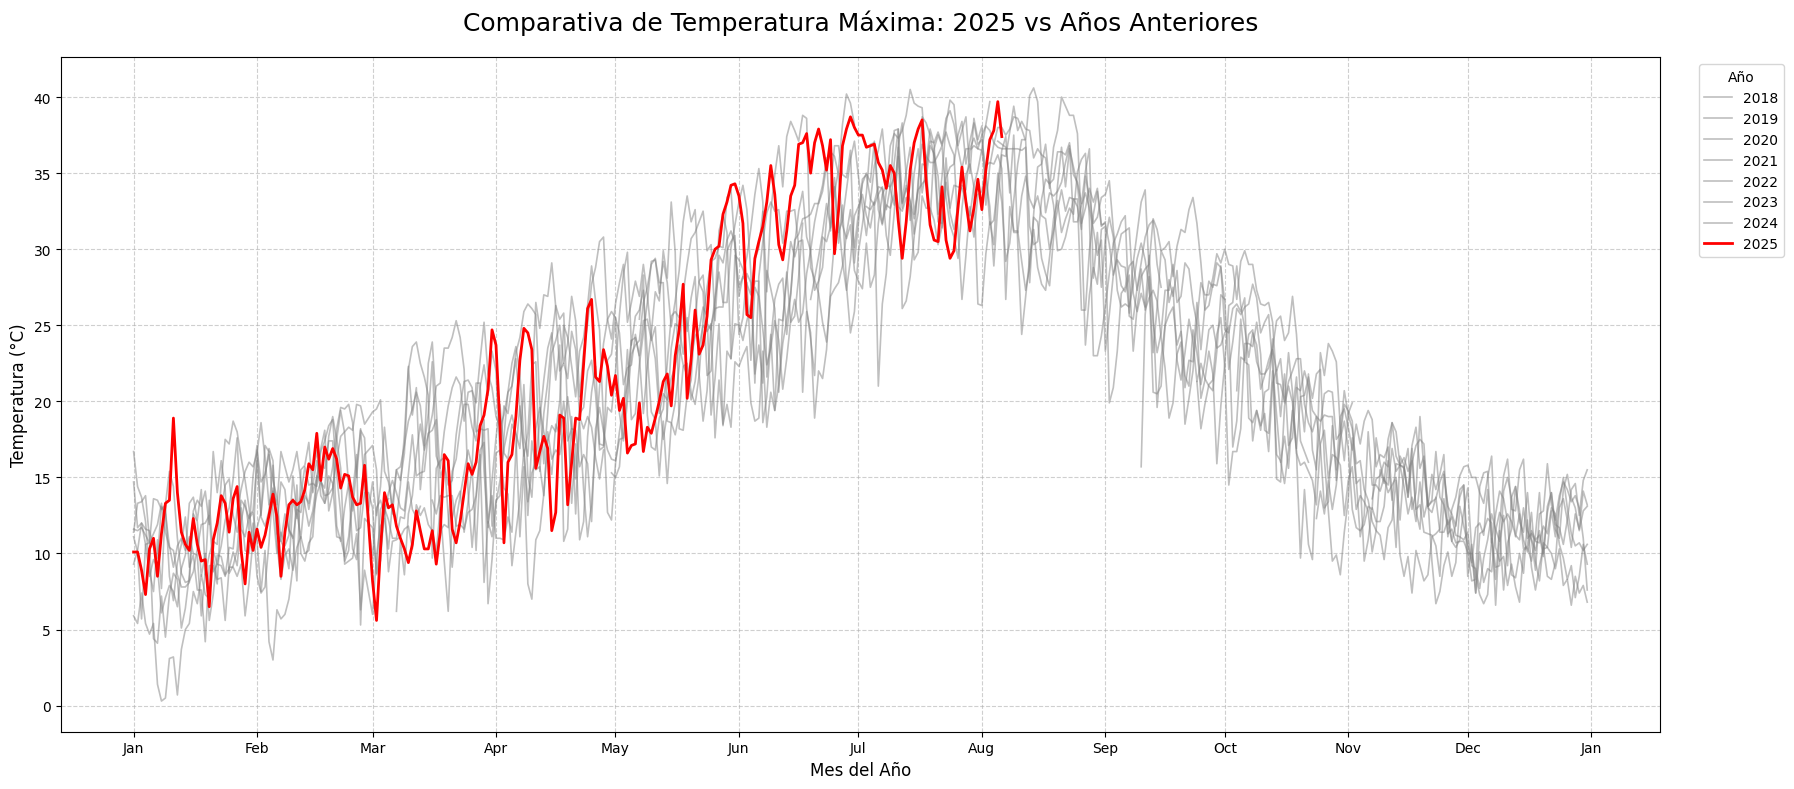

In [20]:
# --- PASO 3: Crear el gráfico con Matplotlib y colores personalizados ---

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(18, 8))

# Variable de temperatura a graficar
variable_temperatura = 'TempMax_C'

# 1. Encontrar el año más reciente en nuestros datos
anio_reciente = df_grafico['Año'].max()
print(f"El año más reciente detectado es: {anio_reciente}. Se destacará en color rojo.")

# Obtener la lista de años para iterar
anios = sorted(df_grafico['Año'].unique())

# Bucle para dibujar una línea por cada año
for anio in anios:
    df_anio = df_grafico[df_grafico['Año'] == anio]
    
    # 2. Lógica condicional para definir el estilo de la línea
    if anio == anio_reciente:
        # Estilo para el año más reciente
        color_linea = 'red'
        alfa = 1.0  # Totalmente opaco
        grosor = 2.0 # Un poco más grueso para destacar
        z_order = 10 # MUY IMPORTANTE: asegura que esta línea se dibuje encima de todas las demás
    else:
        # Estilo para los años anteriores
        color_linea = 'grey'
        alfa = 0.5   # 50% de transparencia para que no saturen la vista
        grosor = 1.2 # Grosor estándar
        z_order = 5  # Se dibuja por debajo de la línea destacada
    
    # 3. Dibujar la línea con el estilo definido
    ax.plot(df_anio['DiaDelAnio'], 
            df_anio[variable_temperatura], 
            label=anio, 
            color=color_linea,
            alpha=alfa,
            linewidth=grosor,
            zorder=z_order)

# --- PASO 4: Personalizar el gráfico (sin cambios) ---
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(f'Comparativa de Temperatura Máxima: {anio_reciente} vs Años Anteriores', fontsize=18, pad=20)
ax.set_xlabel('Mes del Año', fontsize=12)
ax.set_ylabel('Temperatura (°C)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# Crear la leyenda. Matplotlib la ordenará automáticamente.
ax.legend(title='Año', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

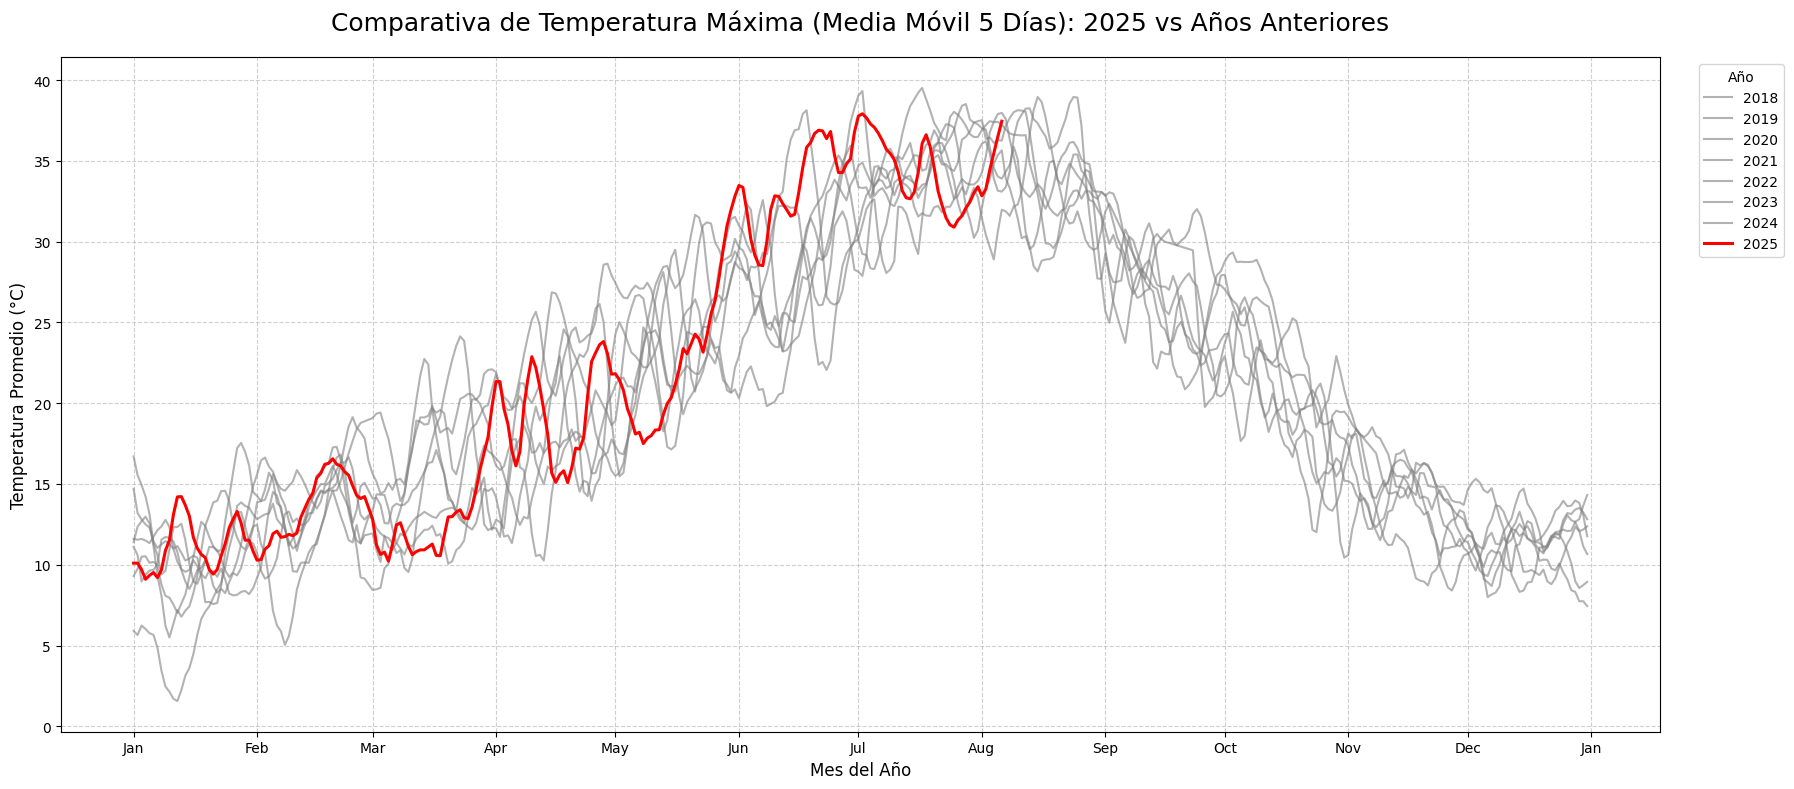

In [21]:
# Calcular la media móvil
variable_temperatura = 'TempMax_C'
df_grafico['TempMax_Suavizada_7d'] = df_grafico.groupby('Año')[variable_temperatura].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# --- Crear el gráfico suavizado con colores personalizados ---
fig, ax = plt.subplots(figsize=(18, 8))
anio_reciente = df_grafico['Año'].max()
anios = sorted(df_grafico['Año'].unique())

for anio in anios:
    df_anio = df_grafico[df_grafico['Año'] == anio]
    
    if anio == anio_reciente:
        color_linea, alfa, grosor, z_order = 'red', 1.0, 2.2, 10
    else:
        color_linea, alfa, grosor, z_order = 'grey', 0.6, 1.5, 5
    
    ax.plot(df_anio['DiaDelAnio'], 
            df_anio['TempMax_Suavizada_7d'], 
            label=anio, 
            color=color_linea,
            alpha=alfa,
            linewidth=grosor,
            zorder=z_order)

# --- Personalización ---
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_title(f'Comparativa de Temperatura Máxima (Media Móvil 5 Días): {anio_reciente} vs Años Anteriores', fontsize=18, pad=20)
ax.set_xlabel('Mes del Año', fontsize=12)
ax.set_ylabel('Temperatura Promedio (°C)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Año', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
def get_gfs_data(url):

#url = 'https://www.meteociel.fr/modeles/gefs_table.php?x=0&y=0&lat=40.4165&lon=-3.70256&run=12&ext=1&mode=7&sort=2'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df

def get_last_gfs_run():

    runs = [0, 6, 12, 18]  # GFS runs at 00, 06, 12, and 18 UTC
    url ='https://www.meteociel.fr/modeles/gefs_table.php?x=0&y=0&lat=40.4165&lon=-3.70256&ext=1&mode=7&sort=2'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_gfs_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_gfs_run()


def get_temp_data_gfs(valid_run):



    url ='https://www.meteociel.fr/modeles/gefs_table.php?x=0&y=0&lat=40.4165&lon=-3.70256&ext=1&mode=7&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_gfs_data(url_run)

    return temp_data

temp_data_gfs = get_temp_data_gfs(valid_run)

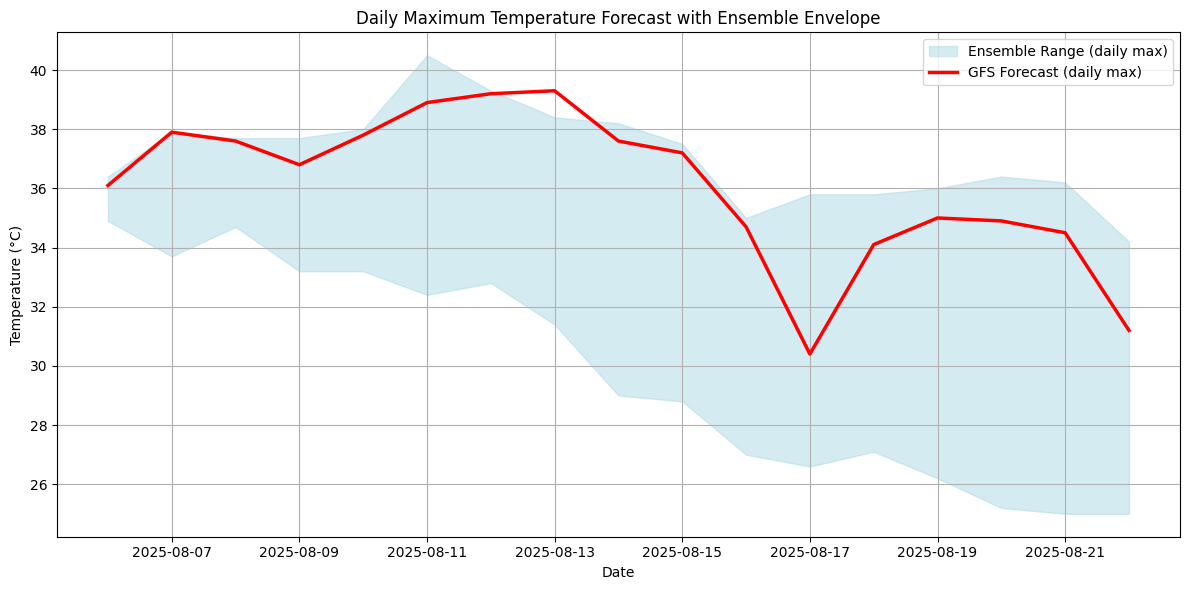

In [ ]:
import matplotlib.pyplot as plt

# Resample the original DataFrame to get the maximum forecast value for each ensemble column per day.
daily_data = temp_data_gfs.resample('D').max()

# Use the daily index for the x-axis
x = daily_data.index

# Select the ensemble columns (all columns except "GFS")
ensemble_cols = [col for col in daily_data.columns if col != "GFS"]

# Compute the lower and upper bounds of the ensemble forecast using daily max values
lower_bound = daily_data[ensemble_cols].min(axis=1)
upper_bound = daily_data[ensemble_cols].max(axis=1)


plt.figure(figsize=(12, 6))

# Plot the ensemble envelope as a filled area
plt.fill_between(x, lower_bound, upper_bound, color="lightblue", alpha=0.5, label="Ensemble Range (daily max)")

# Plot the GFS forecast as a red solid line
plt.plot(x, daily_data["GFS"], color="red", linewidth=2.5, label="GFS Forecast (daily max)")

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Maximum Temperature Forecast with Ensemble Envelope")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
temp_data_gfs.resample('D').max()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,GFS
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-06 00:00:00+02:00,35.9,36.0,35.9,35.4,35.6,36.2,36.1,35.7,35.6,36.1,...,35.4,36.2,36.2,36.1,36.0,36.0,36.3,36.3,36.4,36.1
2025-08-07 00:00:00+02:00,36.6,37.1,37.3,36.2,36.5,37.3,37.1,36.2,36.1,36.8,...,36.2,37.6,36.7,36.2,37.9,36.8,36.3,36.9,37.7,37.9
2025-08-08 00:00:00+02:00,36.4,37.2,37.6,36.4,37.6,37.1,36.7,37.2,36.4,36.0,...,36.2,37.7,37.6,36.5,36.6,36.6,36.0,36.3,37.4,37.6
2025-08-09 00:00:00+02:00,35.7,35.4,35.9,34.5,36.9,33.6,36.0,36.4,36.1,37.1,...,33.2,35.4,37.2,36.4,34.5,37.7,35.7,34.8,35.4,36.8
2025-08-10 00:00:00+02:00,36.3,36.7,37.9,36.1,37.0,33.2,37.0,37.0,35.1,37.3,...,33.5,34.8,38.0,37.6,34.6,38.0,37.1,37.5,34.9,37.8
2025-08-11 00:00:00+02:00,37.1,36.7,35.8,35.1,38.6,33.7,37.6,37.8,32.4,36.7,...,34.8,36.1,34.8,36.2,34.6,38.0,37.0,34.2,35.1,38.9
2025-08-12 00:00:00+02:00,37.1,32.8,34.9,34.2,35.5,35.0,36.3,37.8,36.6,37.7,...,36.9,36.3,33.7,36.8,33.7,37.8,38.0,34.2,38.3,39.2
2025-08-13 00:00:00+02:00,36.5,32.6,34.6,33.4,34.5,36.3,38.1,36.8,32.1,37.1,...,38.4,35.8,35.2,35.2,35.0,37.1,38.1,31.4,33.2,39.3
2025-08-14 00:00:00+02:00,34.3,31.7,33.3,33.3,31.9,31.1,38.2,35.6,29.0,35.1,...,34.2,35.5,33.9,32.1,35.7,36.9,36.5,29.4,34.8,37.6


In [64]:
daily_data_max

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,GFS
Date,,,,,,,,,,,,,,,,,,,,,


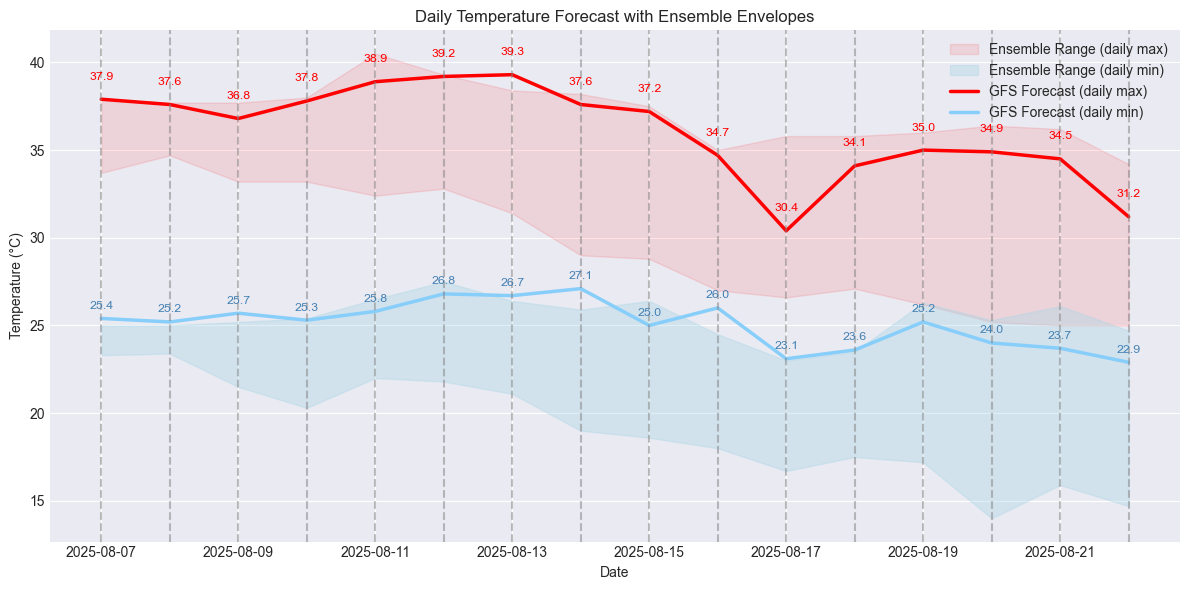

In [ ]:
import streamlit as st

import matplotlib.pyplot as plt

# Resample to get daily forecasts for maximum and minimum temperatures separately
daily_data_max = temp_data_gfs.resample('D').max()
daily_data_min = temp_data_gfs.resample('D').min()

# Exclude the current day
today = pd.Timestamp.now(tz=daily_data_max.index.tz).normalize()
daily_data_max = daily_data_max[daily_data_max.index > today]
daily_data_min = daily_data_min[daily_data_min.index > today]

# Use the same daily index for the x-axis
x = daily_data_max.index

# For the ensemble forecasts, exclude the "GFS" column
ensemble_cols_max = [col for col in daily_data_max.columns if col != "GFS"]
ensemble_cols_min = [col for col in daily_data_min.columns if col != "GFS"]

# Compute the envelope bounds for the maximum forecasts
lower_bound_max = daily_data_max[ensemble_cols_max].min(axis=1)
upper_bound_max = daily_data_max[ensemble_cols_max].max(axis=1)

# Compute the envelope bounds for the minimum forecasts
lower_bound_min = daily_data_min[ensemble_cols_min].min(axis=1)
upper_bound_min = daily_data_min[ensemble_cols_min].max(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot ensemble envelope for daily maximum temperatures
ax.fill_between(x, lower_bound_max, upper_bound_max,
                color="red", alpha=0.1, label="Ensemble Range (daily max)")
# Plot ensemble envelope for daily minimum temperatures
ax.fill_between(x, lower_bound_min, upper_bound_min,
                color="lightblue", alpha=0.4, label="Ensemble Range (daily min)")

# Plot GFS forecast for maximum temperatures
ax.plot(x, daily_data_max["GFS"], color="red", linewidth=2.5,
        label="GFS Forecast (daily max)")
# Plot GFS forecast for minimum temperatures
ax.plot(x, daily_data_min["GFS"], color="lightskyblue", linewidth=2.5,
        label="GFS Forecast (daily min)")

# Add vertical gridlines for each day
for day in x:
    ax.axvline(x=day, color="gray", linestyle="--", alpha=0.5)

# Add small datalabels showing the GFS temperature for each day.
for day, temp in zip(x, daily_data_max["GFS"]):
    ax.text(day, temp + 1, f"{temp:.1f}", ha="center", va="bottom", fontsize=8.9, color="red")
for day, temp in zip(x, daily_data_min["GFS"]):
    ax.text(day, temp - 1, f"{temp:.1f}", ha="center", va="top", fontsize=8.9, color="steelblue")

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Daily Temperature Forecast with Ensemble Envelopes")
ax.legend()
ax.grid(True)
fig.tight_layout()

st.pyplot(fig)


In [85]:
pd.Timestamp.now(tz=daily_data_max.index.tz).normalize()

Timestamp('2025-08-06 00:00:00+0200', tz='Europe/Madrid')

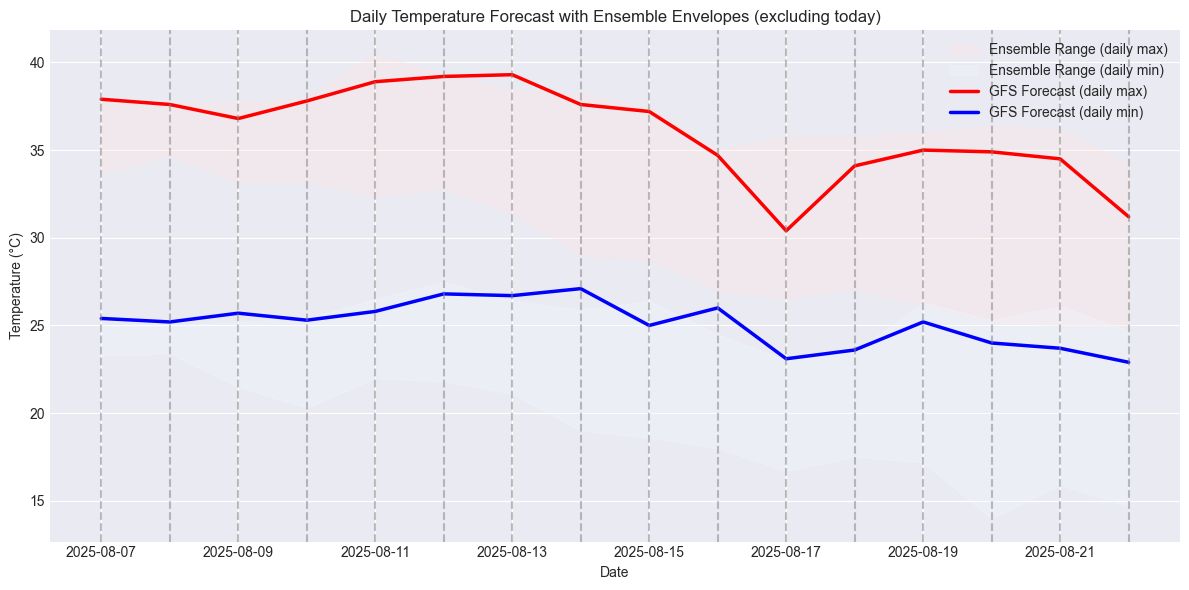

In [86]:
import pandas as pd

import matplotlib.pyplot as plt

# Resample to get daily forecasts for maximum and minimum temperatures separately
daily_data_max = temp_data_gfs.resample('D').max()
daily_data_min = temp_data_gfs.resample('D').min()

# Exclude the current day
today = pd.Timestamp.now(tz=daily_data_max.index.tz).normalize()
daily_data_max = daily_data_max[daily_data_max.index > today]
daily_data_min = daily_data_min[daily_data_min.index > today]

# Use the filtered daily index for the x-axis
x = daily_data_max.index

# For the ensemble forecasts, exclude the "GFS" column
ensemble_cols_max = [col for col in daily_data_max.columns if col != "GFS"]
ensemble_cols_min = [col for col in daily_data_min.columns if col != "GFS"]

# Compute the envelope bounds for the maximum forecasts
lower_bound_max = daily_data_max[ensemble_cols_max].min(axis=1)
upper_bound_max = daily_data_max[ensemble_cols_max].max(axis=1)

# Compute the envelope bounds for the minimum forecasts
lower_bound_min = daily_data_min[ensemble_cols_min].min(axis=1)
upper_bound_min = daily_data_min[ensemble_cols_min].max(axis=1)

plt.figure(figsize=(12, 6))

# Plot the ensemble envelope for daily maximum temperatures with a very light red background
plt.fill_between(x, lower_bound_max, upper_bound_max,
                 color="mistyrose", alpha=0.3, label="Ensemble Range (daily max)")
# Plot the ensemble envelope for daily minimum temperatures with a very light blue background
plt.fill_between(x, lower_bound_min, upper_bound_min,
                 color="aliceblue", alpha=0.3, label="Ensemble Range (daily min)")

# Plot the GFS forecast for the maximum temperatures in red
plt.plot(x, daily_data_max["GFS"], color="red", linewidth=2.5,
         label="GFS Forecast (daily max)")
# Plot the GFS forecast for the minimum temperatures in blue
plt.plot(x, daily_data_min["GFS"], color="blue", linewidth=2.5,
         label="GFS Forecast (daily min)")

# Add a vertical line for each day
for day in x:
    plt.axvline(x=day, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Temperature Forecast with Ensemble Envelopes (excluding today)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
temp_data_gfs



,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,GFS
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-06 14:00:00+02:00,32.9,32.5,33.4,32.9,33.0,32.7,32.7,32.9,32.9,33.2,...,32.9,32.8,33.0,33.4,32.9,32.4,33.8,33.3,33.1,33.8
2025-08-06 17:00:00+02:00,35.9,36.0,35.9,35.4,35.6,36.2,36.1,35.7,35.6,36.1,...,35.4,36.2,36.2,36.1,36.0,36.0,36.3,36.3,36.4,36.1
2025-08-06 20:00:00+02:00,35.5,35.7,35.6,35.1,35.0,35.9,35.5,35.1,35.3,35.7,...,34.4,36.0,35.7,35.3,35.9,35.3,35.5,35.8,35.7,35.7
2025-08-06 23:00:00+02:00,30.9,30.6,31.0,30.5,30.4,31.1,30.6,30.1,30.9,31.1,...,29.8,31.2,30.9,30.2,31.1,30.6,30.8,31.1,31.5,31.9
2025-08-07 02:00:00+02:00,27.8,27.8,28.0,27.5,27.4,28.2,27.8,27.5,28.0,28.2,...,27.0,27.8,28.0,27.5,28.6,27.6,27.9,28.0,28.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21 14:00:00+02:00,35.6,31.3,31.3,29.3,29.5,28.0,28.3,28.9,28.1,25.7,...,34.0,34.3,28.4,31.8,32.8,34.8,31.8,30.5,29.1,31.3
2025-08-21 20:00:00+02:00,36.2,31.0,32.0,32.7,29.8,29.8,27.5,29.9,29.4,20.8,...,34.3,33.1,31.3,32.1,32.6,35.0,33.7,31.3,29.7,34.5
2025-08-22 02:00:00+02:00,28.2,23.6,23.5,23.7,18.4,21.0,22.3,20.6,23.1,19.6,...,23.7,23.3,23.9,24.0,22.9,26.7,26.6,24.0,21.8,25.5
